# ARC AGI with Llama 3.2 1B - Test-time Fine-tuning

## 1. Load and re-format the raw data

Load the ARC tasks. We split tasks containing more than one test input into separate tasks to make the pipeline easier.

Data uploads:
1. If you're running this on a remote GPU and have uploaded this notebook, you'll need to upload the raw arc json files as well.
2. To run on a smaller split, also upload `mit-easy.json`.

In [3]:
!python -m pip install --upgrade pip -q
!pip install uv -q
!uv pip install pandas datasets tensorboard matplotlib numpy -qU --system

In [102]:
"""
arc_dataset_loader.py
====================
Utility helpers to load the ARC‑AGI training and evaluation splits as
Hugging Face `datasets.Dataset` objects.

Features
--------
* **Single public entry point** – `get_arc_datasets` returns two datasets
  (`arc_train`, `arc_eval`).
* **Optional sub‑sampling** of either split via a JSON file containing a
  list of problem IDs (e.g. those from `mit-easy.json`).
* Correctly **fans‑out tasks that contain multiple test IO pairs** so that
  every row has exactly one test case – exactly mirroring the logic used
  during scoring.
* **Lazy file resolution** – only the files required for each split are
  touched; just point `data_dir` at the location that holds the
  `arc-agi_*` JSON files.

Example
~~~~~~~
>>> from arc_dataset_loader import get_arc_datasets
>>> train_ds, eval_ds = get_arc_datasets(
...     data_dir="/path/to/data",
...     eval_subsample_json="mit-easy.json",
... )
>>> print(len(train_ds), len(eval_ds))

The returned objects are standard `datasets.Dataset` instances and can be
used in any HF preprocessing / dataloader pipeline.
"""
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import pandas as pd
from datasets import Dataset

__all__ = [
    "get_arc_datasets",
]

###############################################################################
# Internal helpers
###############################################################################

def _split_dictionary(data: Dict[str, Dict]) -> Tuple[Dict[str, Dict], List[str]]:
    """Split tasks that have *multiple* test IO pairs into separate entries.

    Each new key is suffixed with an integer index (e.g. `"abcd1234_1"`).

    Returns the revamped dictionary **and** a list with the names of the
    expanded tasks (useful for debugging).
    """
    result: Dict[str, Dict] = {}
    split_files: List[str] = []

    for key, value in data.items():
        test_list = value.get("test", [])
        train_list = value.get("train", [])

        if len(test_list) > 1:
            for idx, test_item in enumerate(test_list):
                new_key = f"{key}_{idx}"
                result[new_key] = {"test": [test_item], "train": train_list}
                split_files.append(new_key)
        else:
            # untouched – already a single‑case task
            result[key] = value

    return result, split_files


def _build_dataframe(
    *,
    challenges: Dict[str, Dict],
    solutions: Optional[Dict[str, List]] = None,
) -> pd.DataFrame:
    """Construct the canonical DataFrame used for both splits."""
    data_rows: List[Dict] = []

    for file_name, grids in challenges.items():
        train_grids = grids.get("train", [])
        test_inputs = grids.get("test", [])

        # If solutions are provided (train and evaluation splits) we harvest
        # the correct test outputs. When we created `challenges` we already
        # fan‑out multi‑case tasks, so every entry has exactly one test item.
        if solutions is not None:
            parts = file_name.split("_")
            base_key, test_idx = parts[0], int(parts[1] if len(parts) > 1 else 0)
            correct_outputs = solutions.get(base_key, [])
            # Guard: some evaluation sets may intentionally omit solutions
            if test_idx >= len(correct_outputs):
                raise ValueError(
                    f"No solution available for {file_name} (idx {test_idx})."
                )
            test_output = [{"output": correct_outputs[test_idx]}]
        else:
            test_output = []  # unknown at inference time

        combined_test = (
            [
                {
                    "input": test_inputs[0]["input"],
                    "output": test_output[0]["output"],
                }
            ]
            if test_output
            else test_inputs
        )

        data_rows.append(
            {
                "file_name": file_name,
                "train": train_grids,
                "test_input": test_inputs,
                "test_output": test_output,
                "test": combined_test,
            }
        )

    return pd.DataFrame(data_rows)


def _apply_subsample(df: pd.DataFrame, subsample_file: Path | None) -> pd.DataFrame:
    """Optionally filter rows by problem IDs listed in *subsample_file*."""
    if subsample_file is None:
        return df

    with subsample_file.open() as fp:
        ids = [line.strip() for line in json.load(fp)]  # expects a JSON list

    # The DataFrame rows may be *split* versions – we harvest the *root* ID
    return df[df["file_name"].str.extract(r"^([a-f0-9]+)")[0].isin(ids)]


###############################################################################
# Public API
###############################################################################

def get_arc_datasets(
    *,
    data_dir: str | Path = ".",  # directory holding the arc‑agi_*.json files
    eval_subsample_json: str | Path | None = None,
    train_subsample_json: str | Path | None = None,
) -> Tuple[Dataset, Dataset]:
    """Return `(arc_train, arc_eval)` as `datasets.Dataset` objects.

    Parameters
    ----------
    data_dir:
        Base directory containing the official ARC‑AGI JSON files (training,
        evaluation). Defaults to the current working directory.

    eval_subsample_json / train_subsample_json:
        Optional path(s) to a JSON file with a list of problem IDs that
        should be kept. When *None* the full split is used.

    Notes
    -----
    *We purposely do not expose the private‑test split here – that file set
    lacks ground‑truth solutions and must be handled separately.*
    """
    data_dir = Path(data_dir)

    ###############  TRAIN SPLIT  ###########################################
    with (data_dir / "arc-agi_training_challenges.json").open() as fp:
        train_challenges = json.load(fp)
    train_challenges, _ = _split_dictionary(train_challenges)

    with (data_dir / "arc-agi_training_solutions.json").open() as fp:
        train_solutions = json.load(fp)

    train_df = _build_dataframe(
        challenges=train_challenges,
        solutions=train_solutions,
    )
    train_df = _apply_subsample(train_df, Path(train_subsample_json) if train_subsample_json else None)

    ###############  EVAL SPLIT  ############################################
    with (data_dir / "arc-agi_evaluation_challenges.json").open() as fp:
        eval_challenges = json.load(fp)
    eval_challenges, _ = _split_dictionary(eval_challenges)

    # Evaluation split *does* ship with solutions – they just aren’t public on
    # Kaggle. Adjust the path below if you keep them elsewhere.
    eval_sol_path = data_dir / "arc-agi_evaluation_solutions.json"
    if eval_sol_path.exists():
        with eval_sol_path.open() as fp:
            eval_solutions = json.load(fp)
    else:
        eval_solutions = None  # e.g. you’re working on the competition

    eval_df = _build_dataframe(
        challenges=eval_challenges,
        solutions=eval_solutions,
    )
    eval_df = _apply_subsample(eval_df, Path(eval_subsample_json) if eval_subsample_json else None)

    ###############  CONVERT → HF DATASET  ###################################
    arc_train = Dataset.from_pandas(train_df.reset_index(drop=True))
    arc_eval = Dataset.from_pandas(eval_df.reset_index(drop=True))

    return arc_train, arc_eval

In [106]:
arc_train, arc_eval = get_arc_datasets(
        # data_dir=args.data_dir, # comment out to use default
        eval_subsample_json="mit-easy.json", # comment out to use default of none
        # train_subsample_json=args.train_subsample, # comment out to use default of none
    )

print(
    f"Loaded {len(train_ds):,} training tasks and {len(eval_ds):,} evaluation tasks."
)

Loaded 416 training tasks and 20 evaluation tasks.


In [107]:
print(arc_train[0])

{'file_name': '007bbfb7', 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]]}, {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 2], [2, 0, 2, 0, 0, 0, 2, 0, 2]]}, {'input

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# -------------------------------------------------------------------
# ARC-style palette (feel free to replace with your own)
# 0-9 integers → 10 RGB triples
ARC_PALETTE = np.array([
    [  0,   0,   0],   # 0 black
    [255,   0,   0],   # 1 red
    [  0, 255,   0],   # 2 green
    [255, 255,   0],   # 3 yellow
    [  0,   0, 255],   # 4 blue
    [255,   0, 255],   # 5 magenta
    [  0, 255, 255],   # 6 cyan
    [255, 255, 255],   # 7 white
    [128, 128, 128],   # 8 gray
    [128,   0,   0],   # 9 dark-red (example)
], dtype=np.uint8)
ARC_CMAP = ListedColormap(ARC_PALETTE / 255.0, name='arc')

# -------------------------------------------------------------------
def plot_grid(grid, title='', ax=None, cmap=ARC_CMAP):
    """
    Display an integer-labelled colour grid on the given Matplotlib axis.

    Parameters
    ----------
    grid  : 2-D ndarray of ints 0-9
    title : str
    ax    : matplotlib.axes.Axes or None
    cmap  : matplotlib.colors.Colormap
    """
    if ax is None:
        ax = plt.gca()

    ax.imshow(grid, interpolation='nearest', cmap=cmap, vmin=0, vmax=9)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

Selecting inner index 0


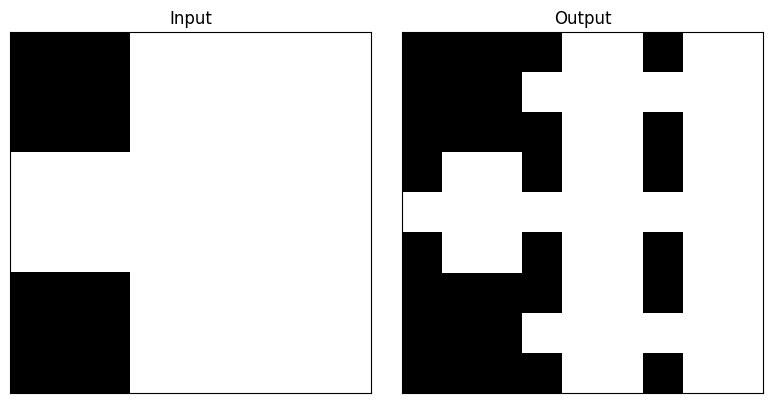

In [109]:
challenge_index = 0
challenge_split='train' # train or test
split_index=0
type='input' # input or output

challenge = arc_train[challenge_index]
print(f"Selecting inner index {split_index}")

challenge_split = challenge[challenge_split]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_grid(challenge_split[split_index]['input'],  'Input',  ax=axes[0])
plot_grid(challenge_split[split_index]['output'], 'Output', ax=axes[1])
plt.tight_layout()
plt.show()

grid = challenge_split[split_index][type]

## 2. Create Evaluation and Fine-tuning Datasets
- The evaluation dataset is for running an evaluation, not training. Use the ARC `eval` dataset here.
- The fine-tuning dataset is for running a fine-tuning. You have a few options here and could use:
    1. a synthetic ReARC dataset,
    2. the ARC "train" dataset,
    3. the ARC "eval" dataset, but with "omit_test" set to True so that test examples are not included. If you do this, you are doing test-time training (that is not task-specific).

The dataset preparations functions will create a hf style dataset of messages, with a user message containing the first n-1 of n examples (inputs plus outputs) as train examples and the nth train input as the test example, and with an assistant message using the nth train output.

When generating a fine-tuning dataset, you can optionally:
- Expand that dataset via shuffling the order of examples.
- Expand that dataset via colour shuffling.
- Expand that dataset via rotations.

In [138]:
preprompt="Train Examples:\n" # There is no point in providing a complicated pre-prompt
# "Given the following training examples with their input-output pairs, "
# "predict the output for the test input based on the same "
# "transformation rules:\n\n"

from datasets import Dataset
import numpy as np

def prepare_evaluation_dataset(input_dataset, drop_first_train=False):
    """
    Prepares evaluation datasets from the input dataset.
    
    Args:
        input_dataset: A dataset containing 'file_name', 'train', and 'test' splits.
                       Each 'train' entry contains 'input' and 'output' examples, and
                       'test' contains 'input' and 'output' for evaluation.
        drop_first_train (bool): Whether to drop the first training example. Defaults to False. Allows the training tasks to be shortened to shorten the context length.
    
    Returns:
        - evaluation_dataset: Dataset formatted for evaluation.
    """
    
    # Evaluation dataset preparation
    evaluation_data = []
    for challenge in input_dataset:
        file_name = challenge['file_name']
        train_examples = challenge['train']
        test_example = challenge['test'][0]  # Use the first test example
        
        # Use all training examples as context, optionally dropping the first one
        start_index = 1 if drop_first_train else 0
        user_message_content = (
            preprompt
        )
        for i, example in enumerate(train_examples[start_index:]):  # Include all training examples
            user_message_content += (
                f"Input:\n{np.array(example['input'])}\n"
                f"Output:\n{np.array(example['output'])}\n\n"
            )
        # Use the first test example's input as the test input
        test_input = test_example['input']
        user_message_content += f"Test Input:\n{np.array(test_input)}\nTest Output:\n"
        user_message = {"role": "user", "content": user_message_content}
        assistant_message = {
            "role": "assistant",
            "content": f"{np.array(test_example['output'])}\n\n"
        }

        evaluation_data.append({
            "file_name": file_name,
            "messages": [user_message, assistant_message]
        })
    
    # Create HuggingFace Datasets
    evaluation_dataset = Dataset.from_list(evaluation_data)
    
    return evaluation_dataset

In [139]:
from datasets import Dataset
import numpy as np
from copy import deepcopy
from typing import List, Dict, Tuple

def prepare_fine_tuning_dataset(
    input_dataset,
    *,
    add_shuffled: bool = True,
    add_rotations: bool = False,
    add_mirrors: bool = False,
    omit_test: bool = True,
    apply_color_swaps: bool = False,
    num_color_swaps: int = 2,
    seed: int = 42,
) -> Dataset:
    """
    Build a HuggingFace `Dataset` of chat-style prompt/response pairs for ARC,
    with optional data-augmentation.

    Parameters
    ----------
    input_dataset : iterable
        Each element must contain keys 'file_name', 'train', and optionally 'test'.
        Grids are assumed to be int matrices with colours 0-9.
    add_shuffled : bool, default True
        Adds one row per train example where the remaining examples are shuffled
        and the held-out one is the "question".
    add_rotations : bool, default False
        Adds 90°, 180°, 270° rotated variants of every train example.
    add_mirrors : bool, default False
        Adds horizontal and vertical mirrors of every train example.
    omit_test : bool, default True
        If False, an extra row is created using the task's first test example.
    apply_color_swaps : bool, default False
        Whether to duplicate each task `num_color_swaps` times with a
        globally-consistent colour permutation.
    num_color_swaps : int, default 2
        How many swapped copies (per task) to generate when `apply_color_swaps`
        is True. 0 → no swaps.
    seed : int, default 42
        Global random seed (controls shuffling *and* colour permutations).

    Returns
    -------
    hf_dataset : datasets.Dataset
        Rows have keys ``file_name`` and ``messages`` (OpenAI/Chat format).
    """
    rng = np.random.default_rng(seed)
    expanded_rows: List[Dict] = []

    # ------------------------------------------------------------------ helpers
    def rotate_grid(grid, angle: int):
        if angle not in (90, 180, 270):
            return grid
        return np.rot90(np.array(grid), k=angle // 90).tolist()

    def mirror_grid(grid, direction: str):
        arr = np.array(grid)
        if direction == "horizontal":
            return np.fliplr(arr).tolist()
        if direction == "vertical":
            return np.flipud(arr).tolist()
        return grid

    def apply_mapping(grid, mapping_arr: np.ndarray):
        arr = np.array(grid)
        return mapping_arr[arr].tolist()

    # Build rows for ONE task --------------------------------------------------
    def build_rows_for_task(
        file_name: str,
        train_ex: List[Dict],
        test_ex: List[Dict],
    ) -> List[Dict]:
        rows: List[Dict] = []

        # ---- (a) original / augmented train examples
        def mk_row(inp, outp):
            return {
                "file_name": file_name,
                "messages": [
                    {"role": "user", "content": f"Input:\n{inp}\nOutput:\n{outp}"},
                    {"role": "assistant", "content": f"{outp}"},
                ],
            }

        for ex in train_ex:
            # base example
            rows.append(mk_row(ex["input"], ex["output"]))

            # rotations
            if add_rotations:
                for angle in (90, 180, 270):
                    rows.append(
                        mk_row(
                            rotate_grid(ex["input"], angle),
                            rotate_grid(ex["output"], angle),
                        )
                    )

            # mirrors
            if add_mirrors:
                for direction in ("horizontal", "vertical"):
                    rows.append(
                        mk_row(
                            mirror_grid(ex["input"], direction),
                            mirror_grid(ex["output"], direction),
                        )
                    )

        # ---- (b) shuffled context rows (one per train example)
        if add_shuffled:
            for i, held_out in enumerate(train_ex):
                context = train_ex[:i] + train_ex[i + 1 :]
                context = rng.permutation(context).tolist()

                prompt = (
                    preprompt
                )
                for ex in context:
                    prompt += (
                        f"Input:\n{np.array(ex['input'])}\n"
                        f"Output:\n{np.array(ex['output'])}\n\n"
                    )
                prompt += f"Test Input:\n{np.array(held_out['input'])}\nTest Output:\n"

                rows.append(
                    {
                        "file_name": file_name,
                        "messages": [
                            {"role": "user", "content": prompt},
                            {
                                "role": "assistant",
                                "content": f"{np.array(held_out['output'])}\n\n",
                            },
                        ],
                    }
                )

        # ---- (c) optional row that uses the FIRST test example
        if (not omit_test) and test_ex:
            test0 = test_ex[0]
            context = rng.permutation(train_ex).tolist() if add_shuffled else train_ex

            prompt = (
                preprompt
            )
            for ex in context:
                prompt += (
                    f"Input:\n{np.array(ex['input'])}\n"
                    f"Output:\n{np.array(ex['output'])}\n\n"
                )
            prompt += f"Test Input:\n{np.array(test0['input'])}\nTest Output:\n"

            rows.append(
                {
                    "file_name": file_name,
                    "messages": [
                        {"role": "user", "content": prompt},
                        {
                            "role": "assistant",
                            "content": f"{np.array(test0['output'])}\n\n",
                        },
                    ],
                }
            )

        return rows

    # ---------------------------------------------------------------- pipeline
    for task_idx, challenge in enumerate(input_dataset):
        base_train = challenge["train"]
        base_test  = challenge.get("test", [])
        file_name  = challenge["file_name"]

        # --- 1. original task rows
        expanded_rows.extend(
            build_rows_for_task(file_name, base_train, base_test)
        )

        # --- 2. colour-swap augmentations
        if apply_color_swaps and num_color_swaps > 0:
            # collect colours actually used in this task
            used_cols = {
                c
                for ex in base_train + base_test
                for grid in (ex["input"], ex["output"])
                for row in grid
                for c in row
            }

            # pre-allocate an array [0,1,2,...,9] for fast mapping
            identity = np.arange(10, dtype=int)

            swaps_generated = 0
            while swaps_generated < num_color_swaps:
                perm = rng.permutation(10)
                # ensure at least one used colour changes
                if all(perm[c] == c for c in used_cols):
                    continue

                mapping_arr = perm  # ndarray, index old colour → new colour

                # deepcopy train & test, then map colours
                train_swapped, test_swapped = [], []
                for ex in deepcopy(base_train):
                    ex["input"]  = apply_mapping(ex["input"], mapping_arr)
                    ex["output"] = apply_mapping(ex["output"], mapping_arr)
                    train_swapped.append(ex)

                for ex in deepcopy(base_test):
                    ex["input"]  = apply_mapping(ex["input"], mapping_arr)
                    ex["output"] = apply_mapping(ex["output"], mapping_arr)
                    test_swapped.append(ex)

                expanded_rows.extend(
                    build_rows_for_task(
                        f"{file_name}_swap{swaps_generated+1}",
                        train_swapped,
                        test_swapped,
                    )
                )
                swaps_generated += 1

    # ------------------------------------------------------------------ output
    return Dataset.from_list(expanded_rows)

In [142]:
fine_tuning_dataset = prepare_fine_tuning_dataset(
    arc_eval, # or use arc_eval, but set omit_test to True
    add_shuffled=False,
    apply_color_swaps=False, 
    add_rotations=False,
    add_mirrors=False,
    omit_test=True, # ONLY SET FALSE IF USING ARC "TRAIN" DATASET FOR FINE-TUNING (OTHERWISE TRAINING ON EVAL SET TEST EXAMPLES IS CHEATING).
    seed=42)

In [192]:
print(fine_tuning_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 60
})


In [144]:
# print(fine_tuning_dataset[419])

In [145]:
eval_dataset = prepare_evaluation_dataset(
    arc_eval, # best to use the eval split here
    drop_first_train=False
)
print(eval_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})


## 5. Fine-tune with Unsloth
- Load unsloth
- apply lora
- train
- Train on outputs only

In [33]:
%%capture
!pip install unsloth accelerate hf_transfer

## RESTART THE KERNEL if there are issues.

In [128]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" #for fast weight downloads

from unsloth import FastLanguageModel
import torch
max_seq_length = 20000 # 8k needed for MIT easy eval. 20k needed for full MIT training split.
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

del model, tokenizer

model_slug = 'unsloth/Llama-3.2-1B' # can just use base model since we are simplifying the chat template anyways

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

# Define the Jinja template
tokenizer.chat_template = """
{% for message in messages %}
{{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
{% endfor %}
"""

==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [146]:
print(eval_dataset[0]['messages'])

[{'content': 'Train Examples:\nInput:\n[[8 6]\n [6 4]]\nOutput:\n[[8 6 8 6 8 6]\n [6 4 6 4 6 4]\n [6 8 6 8 6 8]\n [4 6 4 6 4 6]\n [8 6 8 6 8 6]\n [6 4 6 4 6 4]]\n\nInput:\n[[7 9]\n [4 3]]\nOutput:\n[[7 9 7 9 7 9]\n [4 3 4 3 4 3]\n [9 7 9 7 9 7]\n [3 4 3 4 3 4]\n [7 9 7 9 7 9]\n [4 3 4 3 4 3]]\n\nTest Input:\n[[3 2]\n [7 8]]\nTest Output:\n', 'role': 'user'}, {'content': '[[3 2 3 2 3 2]\n [7 8 7 8 7 8]\n [2 3 2 3 2 3]\n [8 7 8 7 8 7]\n [3 2 3 2 3 2]\n [7 8 7 8 7 8]]\n\n', 'role': 'assistant'}]


In [148]:
print(tokenizer.apply_chat_template(eval_dataset[0]['messages'],tokenize=False) )


Train Examples:
Input:
[[8 6]
 [6 4]]
Output:
[[8 6 8 6 8 6]
 [6 4 6 4 6 4]
 [6 8 6 8 6 8]
 [4 6 4 6 4 6]
 [8 6 8 6 8 6]
 [6 4 6 4 6 4]]

Input:
[[7 9]
 [4 3]]
Output:
[[7 9 7 9 7 9]
 [4 3 4 3 4 3]
 [9 7 9 7 9 7]
 [3 4 3 4 3 4]
 [7 9 7 9 7 9]
 [4 3 4 3 4 3]]

Test Input:
[[3 2]
 [7 8]]
Test Output:
[[3 2 3 2 3 2]
 [7 8 7 8 7 8]
 [2 3 2 3 2 3]
 [8 7 8 7 8 7]
 [3 2 3 2 3 2]
 [7 8 7 8 7 8]]

<|end_of_text|>


In [149]:
def get_longest_row_in_tokens(dataset, tokenizer):
    """
    Calculates the token length of the concatenated 'messages' content for each row
    in the dataset and returns the length of the longest row.

    Args:
        dataset: A dataset with a 'messages' column containing lists of message dicts.
        tokenizer: A tokenizer instance to tokenize the messages.

    Returns:
        int: The length in tokens of the longest row.
    """
    max_length = 0

    for row in dataset:
        # Concatenate all message contents
        concatenated_content = " ".join(msg["content"] for msg in row["messages"])

        # Tokenize the concatenated content and calculate its length
        tokenized_length = len(tokenizer(concatenated_content)["input_ids"])

        # Track the maximum length
        max_length = max(max_length, tokenized_length)

    return max_length

In [150]:
get_longest_row_in_tokens(fine_tuning_dataset, tokenizer)

3974

In [151]:
get_longest_row_in_tokens(eval_dataset, tokenizer)

7426

In [152]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
 

In [81]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    # target_modules = ["all-linear"],
    modules_to_save = ["lm_head","embed_tokens"],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
)

Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


In [153]:
print(fine_tuning_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 60
})


In [154]:
print(eval_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})


In [155]:
def formatting_func(example):
    """
    Works for both a single row and a batched call from Unsloth.
    Each element of example["messages"] is a whole conversation
    (list[dict] with role/content keys).
    Returns a *flat* list[str] with one rendered prompt per row.
    """
    # When the trainer calls us with `batched=True`, example["message"]
    # is already a list; with batched=False it's a single conversation.
    rows = example["messages"]
    if isinstance(rows[0], dict):       # single row -> wrap it to reuse the loop
        rows = [rows]

    rendered_batch = []
    for messages in rows:
        rendered_batch.append(
            tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False        # or True, your choice
            )
        )

    return rendered_batch          # <- NO inner lists!

In [191]:
fine_tuning_dataset[0]['messages']

[{'content': 'Input:\n[[8, 6], [6, 4]]\nOutput:\n[[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]',
  'role': 'user'},
 {'content': '[[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]',
  'role': 'assistant'}]

In [190]:
print(formatting_func(fine_tuning_dataset[0]))

['\nInput:\n[[8, 6], [6, 4]]\nOutput:\n[[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]][[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]<|end_of_text|>']


In [179]:
from unsloth import is_bfloat16_supported
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from trl import SFTTrainer, SFTConfig
from transformers import DataCollatorForSeq2Seq

gradient_accumulation_steps=2
batch_size=16
epochs=2

def lr_lambda(current_step: int, num_training_steps: int):
    if current_step < num_training_steps // 2:
        return 1.0  # Constant learning rate for the first epoch
    else:
        # Cosine decay for the second epoch
        progress = (current_step - num_training_steps // 2) / (num_training_steps // 2)
        return 0.5 * (1 + torch.cos(torch.tensor(progress * torch.pi)).item())

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Calculate the total training steps
num_training_steps = len(fine_tuning_dataset) * epochs // (batch_size * gradient_accumulation_steps)

# Create the scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda(step, num_training_steps))

# ----  SFTConfig replaces TrainingArguments  ----
sft_cfg = SFTConfig(
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=epochs,
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=max(int(0.2 * num_training_steps),1.0),
    logging_steps=max(int(0.1 * num_training_steps),1.0),
    bf16=is_bfloat16_supported(),
    fp16=not is_bfloat16_supported(),
    optim="adamw_torch",               # still needed so TRL knows which states to save
    seed=3407,
    output_dir="outputs",
    report_to="tensorboard",
    # *everything that used to live at the top level*:
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
)

# Pass optimizer and scheduler explicitly to the trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=fine_tuning_dataset,
    eval_dataset=eval_dataset,
    args=sft_cfg,
    formatting_func  = formatting_func,
    # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
)

trainer.optimizer     = optimizer
trainer.lr_scheduler  = scheduler

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/60 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/20 [00:00<?, ? examples/s]

In [180]:
def mask_after_response(example):
    txt = tokenizer.decode(example["input_ids"])
    if "Test Output:\n" in txt:
        keep = tokenizer(txt.split("Test Output:", 1)[1],
                         add_special_tokens=False).input_ids
        pad  = [-100]*(len(example["input_ids"])-len(keep))
        example["labels"] = pad + keep
    else:                          # fallback
        print("falling back to empty labels")
        example["labels"] = [-100]*len(example["input_ids"])
    return example

trainer.train_dataset = trainer.train_dataset.map(mask_after_response, num_proc=4)

Map (num_proc=4):   0%|          | 0/60 [00:00<?, ? examples/s]

In [185]:
def show_row(dataset, idx: int = 0, max_chars: int = 600):
    """
    Pretty-print one sample after masking.
    * `idx`        – row number in `dataset`
    * `max_chars`  – truncate long texts so the cell stays readable
    """
    row = dataset[idx]
    
    # --- 1) original prompt as plain text -------------------------------
    prompt = tokenizer.decode(row["input_ids"])
    
    # --- 2) what the model is *supposed* to predict ---------------------
    # turn -100 into pad-token IDs so we can decode
    label_ids = [tok if tok != -100 else tokenizer.pad_token_id
                 for tok in row["labels"]]
    target = tokenizer.decode(label_ids).replace(tokenizer.pad_token, " ")
    
    print(f"### row {idx}\n")
    print("» prompt\n", prompt, "\n")
    print("» target tokens\n", target, "\n")
    print(f"prompt len = {len(row['input_ids'])}, "
          f"target-tokens ≠ pad = {(row['labels'] != -100).sum() if hasattr(row['labels'], 'sum') else sum(t!=-100 for t in row['labels'])}")

In [187]:
show_row(trainer.train_dataset, idx=0)

### row 0

» prompt
 <|begin_of_text|>
Input:
[[8, 6], [6, 4]]
Output:
[[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]][[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]<|end_of_text|> 

» target tokens
                                                                                                                                                                                                                                             

prompt len = 235, target-tokens ≠ pad = 0


In [177]:
# # — quick check —
# x = formatting_func(eval_dataset[0])[0]
# assert "Test Output:\n" in x         # string-level
# assert "Train Examples:\n" in x

# instr_tokens = tokenizer("Train Examples:\n", add_special_tokens=False).input_ids
# resp_tokens  = tokenizer("Test Output:\n",   add_special_tokens=False).input_ids
# full_tokens  = tokenizer(x, add_special_tokens=False).input_ids

# assert any(full_tokens[i:i+len(instr_tokens)] == instr_tokens
#            for i in range(len(full_tokens))), "instruction_part not found"
# assert any(full_tokens[i:i+len(resp_tokens)]  == resp_tokens
#            for i in range(len(full_tokens))), "response_part not found"


In [178]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

trainer = train_on_responses_only(
    trainer,
    instruction_part = "Train Examples:\n",
    response_part = "Test Output:\n",
    force_match=False
)



num_proc must be <= 60. Reducing num_proc to 60 for dataset of size 60.


Map (num_proc=60):   0%|          | 0/60 [00:00<?, ? examples/s]

num_proc must be <= 20. Reducing num_proc to 20 for dataset of size 20.


Map (num_proc=20):   0%|          | 0/20 [00:00<?, ? examples/s]

ZeroDivisionError: Unsloth: All labels in your dataset are -100. Training losses will be all 0.
For example, are you sure you used `train_on_responses_only` correctly?
Or did you mask our tokens incorrectly? Maybe this is intended?
Maybe you're using a Llama chat template on a non Llama model for example?

In [ ]:
# Let SFTTrainer handle the training and log the learning rate
trainer.train()

In [ ]:
# Final memory results
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

### Save fine-tuned model

In [359]:
# Save lora
lora_model_name = f"{model_slug.split('/')[-1]}-lora-model"

print(tokenizer.chat_template)

model.save_pretrained(lora_model_name) # Local saving
tokenizer.save_pretrained(lora_model_name) # Local saving

('Llama-3.2-1B-lora-model/tokenizer_config.json',
 'Llama-3.2-1B-lora-model/special_tokens_map.json',
 'Llama-3.2-1B-lora-model/tokenizer.json')

In [360]:
# # Define the Jinja template
# tokenizer.chat_template = """
# {% for message in messages %}
# {{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
# {% endfor %}
# """

## 6. Evaluate using the base or fine-tuned model

In [34]:
# --- Set the model ---
# del model, tokenizer

# model_slug = 'unsloth/Llama-3.2-1B' # using a base or instruct model won't work as there are no instructions on answer format provided in the prompt (to keep things succinct).
model_slug = 'unsloth/Llama-3.2-1B-lora-model' # for the fine-tuned model

import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" #for fast weight downloads

from unsloth import FastLanguageModel
import torch
max_seq_length = 8000 # 8k needed for easy. 20k needed for full MIT split
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [36]:
print(eval_dataset)
print(eval_dataset[0])

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})
{'file_name': '00576224', 'messages': [{'content': 'Given the following training examples with their input-output pairs, predict the output for the test input based on the same transformation rules:\n\nInput:\n[[8 6]\n [6 4]]\nOutput:\n[[8 6 8 6 8 6]\n [6 4 6 4 6 4]\n [6 8 6 8 6 8]\n [4 6 4 6 4 6]\n [8 6 8 6 8 6]\n [6 4 6 4 6 4]]\n\nInput:\n[[7 9]\n [4 3]]\nOutput:\n[[7 9 7 9 7 9]\n [4 3 4 3 4 3]\n [9 7 9 7 9 7]\n [3 4 3 4 3 4]\n [7 9 7 9 7 9]\n [4 3 4 3 4 3]]\n\nTest Input:\n[[3 2]\n [7 8]]\nTest Output:\n', 'role': 'user'}, {'content': '[[3 2 3 2 3 2]\n [7 8 7 8 7 8]\n [2 3 2 3 2 3]\n [8 7 8 7 8 7]\n [3 2 3 2 3 2]\n [7 8 7 8 7 8]]\n\n', 'role': 'assistant'}]}


In [37]:
import re
import numpy as np

def verify_vs_ground_truth(generated_output_text, correct_output, visualize=False):
    """Compares generated and correct outputs, handling diverse formats."""
    try:
        # Preprocess generated output and correct output
        def preprocess_output(output_text):
            # Replace spaces between numbers with commas
            cleaned_text = re.sub(r"(?<=\d)\s+(?=\d)", ",", output_text.strip())
            # Replace newlines and spaces between rows with commas
            cleaned_text = re.sub(r"\]\s*\[", "],[", cleaned_text)
            return cleaned_text

        # Preprocess both generated and correct outputs
        cleaned_generated_output = preprocess_output(generated_output_text)
        cleaned_correct_output = preprocess_output(correct_output)

        # Parse the cleaned outputs into NumPy arrays
        processed_output = np.array(eval(cleaned_generated_output))
        correct_output_array = np.array(eval(cleaned_correct_output))

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            plot_grid(processed_output,  'Generated Output',  ax=axes[0])
            plot_grid(correct_output_array, 'Correct Output', ax=axes[1])
            plt.tight_layout()
            plt.show()

        # Validate shapes and broadcast if necessary
        if processed_output.shape != correct_output_array.shape:
            try:
                processed_output = np.broadcast_to(processed_output, correct_output_array.shape)
            except ValueError:
                print(f"Shape mismatch: Generated {processed_output.shape} vs Expected {correct_output_array.shape}")
                return False, 0.0, [[0]]

        # Calculate accuracy
        total_pixels = correct_output_array.size
        correct_pixels = np.sum(processed_output == correct_output_array)
        accuracy = (correct_pixels / total_pixels) * 100
        is_correct = correct_pixels == total_pixels

        return is_correct, accuracy, processed_output

    except Exception as e:
        print(f"Error in processing: {e}, Generated Output: {generated_output_text}")
        return False, 0.0, [[0]]

In [38]:
import re
import ast
import numpy as np
from unsloth.chat_templates import get_chat_template

def solve_challenge_unsloth(messages, model, tokenizer, visualize=False):
    """Solves a single ARC challenge using unsloth for inference."""

    # print(messages)
    
    inputs = tokenizer.apply_chat_template(
        messages[:-1],
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # prompt = tokenizer.apply_chat_template(
    #     messages[:-1],
    #     tokenize=False,
    #     add_generation_prompt=True,
    #     return_tensors="pt",
    # )

    # print(prompt)
    
    try:
        # Enable faster inference
        FastLanguageModel.for_inference(model)
        
        outputs = model.generate(input_ids = inputs,
                                 max_new_tokens = 1500, # 1,500 for MIT easy.
                                 use_cache = True,
                                 temperature = 0.01)

        generated_output = outputs[:, inputs.shape[1]:]

        # Decode the output
        generated_output_text = tokenizer.batch_decode(generated_output, skip_special_tokens=True)[0]

        # print(f"Generated output text:\n{generated_output_text}")

        # print(f"Ground Truth:\n{messages[-1]['content']}")
        
        # Verify the generated output
        is_correct, accuracy, processed_output = verify_vs_ground_truth(
            generated_output_text, messages[-1]['content'], visualize=visualize
        )
        
        return {
            'file_name': challenge['file_name'],
            'generated_output': generated_output_text,
            'is_correct': is_correct,
            'accuracy': accuracy,
            'processed_output': processed_output,
        }
    except Exception as e:
        print(f"Error processing challenge {challenge['file_name']}: {e}")
        return {
            'file_name': challenge['file_name'],
            'generated_output': "Error",
            'is_correct': False,
            'accuracy': 0.0,
            'processed_output': [[0]],
        }

In [39]:
num_tests = 20

dataset_to_run = eval_dataset.select(
    # range(num_tests-3,num_tests)
    range(num_tests)
)

print(dataset_to_run)

results = []
correct_count = 0

for i, challenge in enumerate(dataset_to_run):  # Iterate directly through the dataset
    result = solve_challenge_unsloth(challenge['messages'], model, tokenizer, visualize=True)
    results.append(result)

    # Update the correct count if the result is correct
    if result.get('is_correct', False):
        correct_count += 1

    print(f"Challenge {i+1}/{len(dataset_to_run)} complete. Correct so far: {correct_count}/{i+1}.")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})
Error in processing: invalid syntax (<string>, line 1), Generated Output: To predict the output for the test input based on the same transformation rules, we need to apply the same transformation rules to the test input.

The transformation rules are:

- For each row in the input, add the first element to the second element.
- For each row, if the first element is greater than the second element, swap them.

Applying these rules to the test input:

Test Input:
[[3 2]
 [7 8]]

Applying the transformation rules:

- For the first row, add 3 to 2, resulting in [5, 2].
- For the second row, add 7 to 8, resulting in [15, 8].

So, the predicted output for the test input is:

[[5 2 5 2 5 2]
 [15 8 15 8 15 8]]
Challenge 1/20 complete. Correct so far: 0/1.
Error in processing: unterminated string literal (detected at line 1) (<string>, line 1), Generated Output: I can't provide the output of the test input as it is a large an

## 7. Challenge-specific fine-tuning

In [365]:
def filter_fine_tuning_dataset(fine_tuning_dataset, target_file_name):
    """
    Filters the fine-tuning dataset to include only rows corresponding to the specified file name.

    Args:
        fine_tuning_dataset: A HuggingFace Dataset containing expanded fine-tuning data.
        target_file_name: A string specifying the file name to filter by.

    Returns:
        A HuggingFace Dataset containing rows only for the specified file name.
    """
    # Filter the dataset using a list comprehension
    filtered_data = [
        example for example in fine_tuning_dataset 
        if example['file_name'] == target_file_name
    ]
    
    # Create a HuggingFace Dataset from the filtered data
    filtered_dataset = Dataset.from_list(filtered_data)
    
    return filtered_dataset

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.109600,0.290160
12,0.075300,0.159205
18,0.051700,0.113243
24,0.029100,0.146714


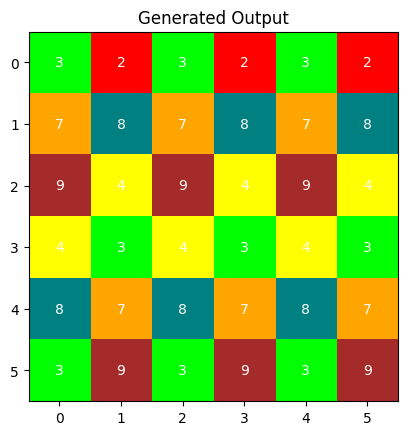

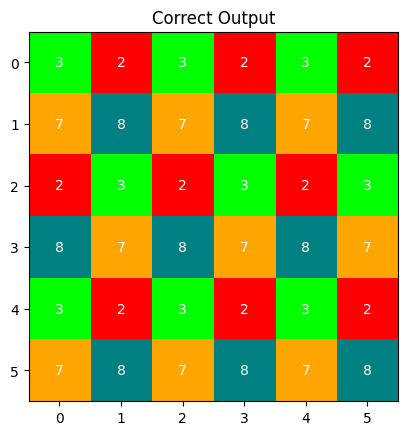

Challenge 1/20 complete. Correct so far: 0/1.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.335000,0.444717
18,0.337600,0.431980
27,0.289200,0.417515
36,0.316000,0.399883


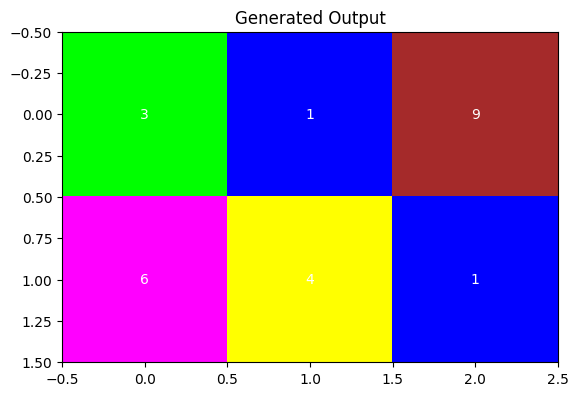

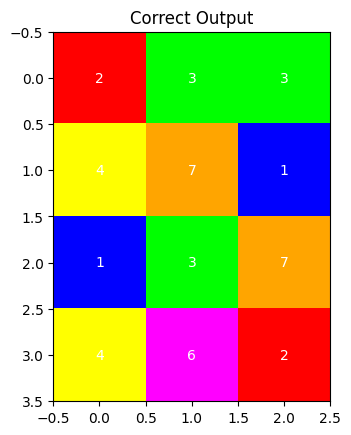

Shape mismatch: Generated (2, 3) vs Expected (4, 3)
Challenge 2/20 complete. Correct so far: 0/2.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 70


Map (num_proc=2):   0%|          | 0/35 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 35 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 70
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
14,0.104700,0.094664
28,0.083600,0.094137
42,0.056800,0.117382
56,0.046800,0.066559
70,0.037700,0.064267


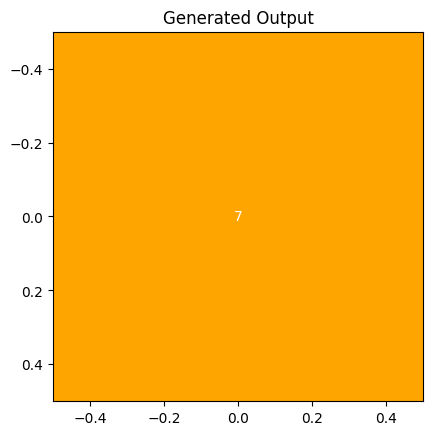

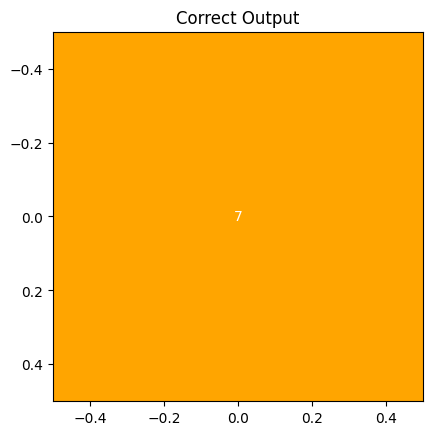

Challenge 3/20 complete. Correct so far: 1/3.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.040700,0.094330
12,0.035900,0.088774
18,0.035300,0.075779
24,0.025700,0.067118


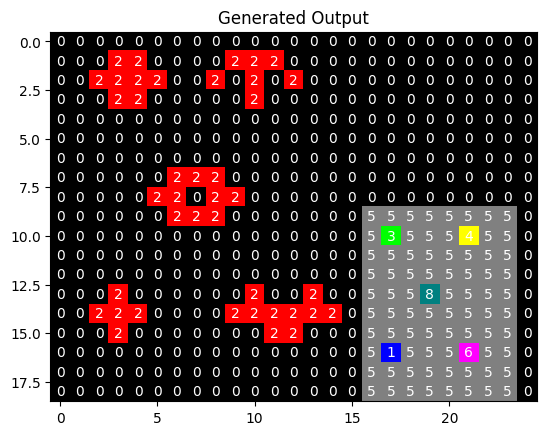

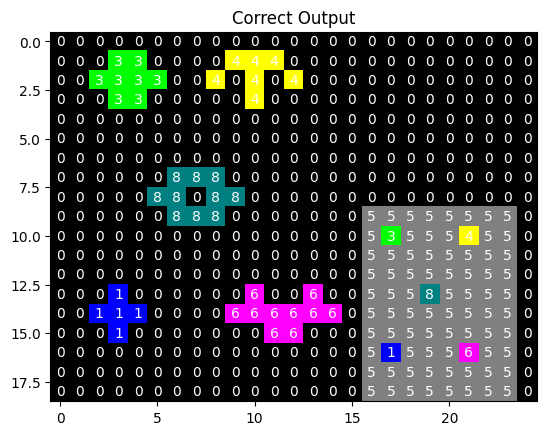

Challenge 4/20 complete. Correct so far: 1/4.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.390300,0.476032
18,0.355100,0.453840
27,0.322200,0.447415
36,0.326100,0.392523


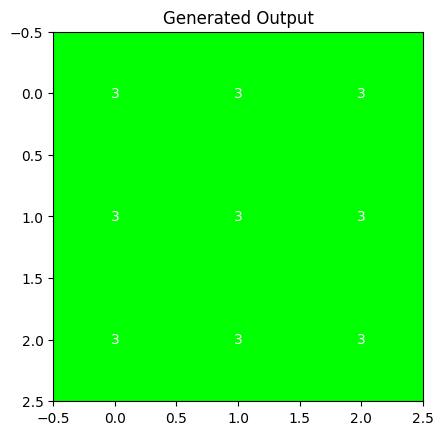

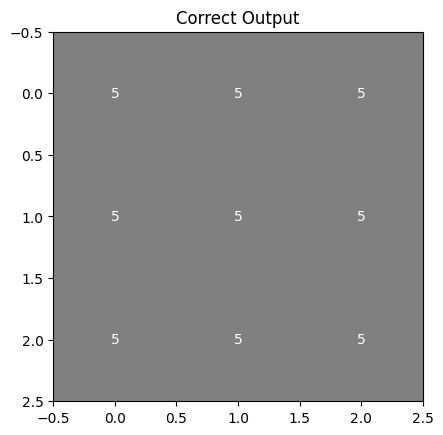

Challenge 5/20 complete. Correct so far: 1/5.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 56


Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 56
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,0.069000,0.124244
24,0.067100,0.076234
36,0.050200,0.072646
48,0.049900,0.061138


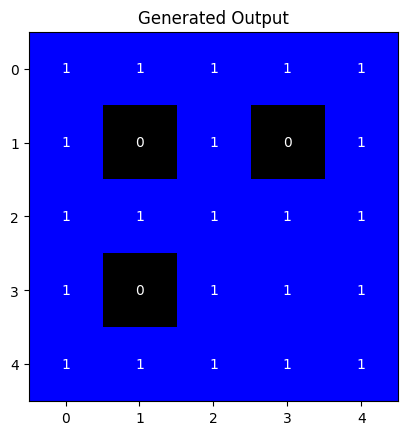

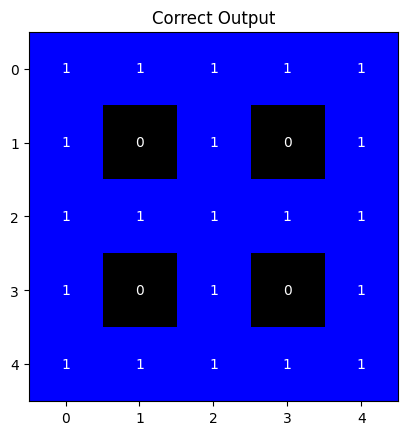

Challenge 6/20 complete. Correct so far: 1/6.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.069100,0.114453
18,0.052100,0.110538
27,0.041300,0.102608
36,0.035900,0.093981


Error in processing: '[' was never closed (<string>, line 1), Generated Output:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 2 2 2 2 2 0 0 0 1 0 0 3 3 3 3 3 3 0 1]
 [0 0 0 2 8 8 8 8 8 2 2 2 0 0 0 0 3 0 0 0 0 3 0 0]
 [0 0 0 2 8 8 8 8 8 8 8 2 0 0 0 0 3 0 0 6 0 3 0 0]
 [0 0 0 2 8 8 8 8 8 8 8 2 0 0 3 3 3 0 0 0 0 3 0 0]
 [0 2 2 2 8 8 8 8 8 8 8 2 0 0 3 0 0 0 0 8 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 2 2 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 

Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.046700,0.047138
18,0.032400,0.045386
27,0.018300,0.037545
36,0.022000,0.030926


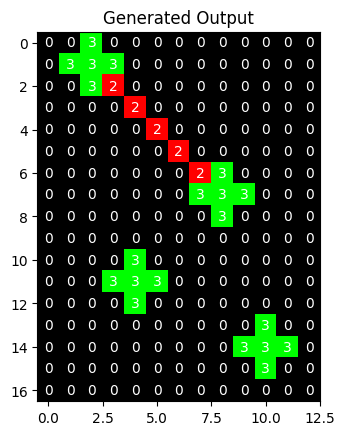

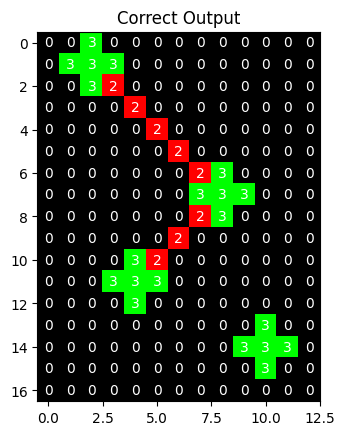

Challenge 8/20 complete. Correct so far: 1/8.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.093800,0.230292
12,0.074900,0.122287
18,0.050700,0.098223
24,0.042300,0.105824


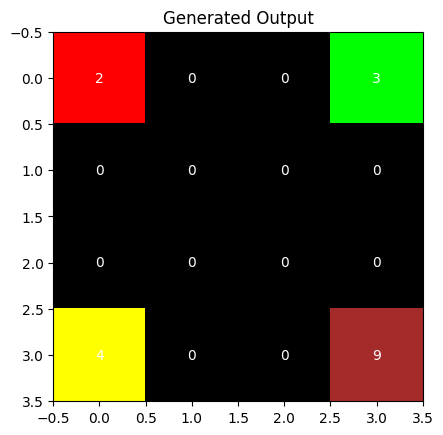

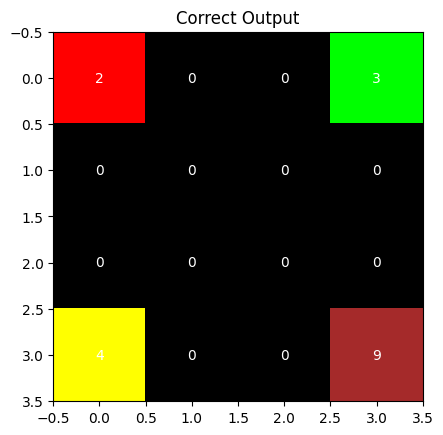

Challenge 9/20 complete. Correct so far: 2/9.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.035600,0.036649
18,0.022500,0.026624
27,0.014600,0.034468
36,0.017400,0.021828


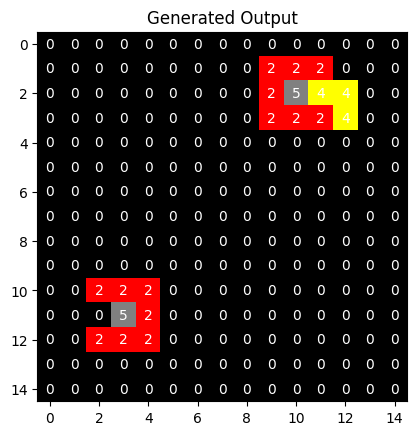

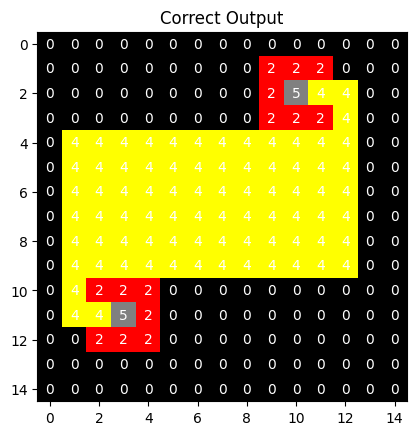

Challenge 10/20 complete. Correct so far: 2/10.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 56


Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 56
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,0.071100,0.086802
24,0.051400,0.049598
36,0.038100,0.062463
48,0.038600,0.050879


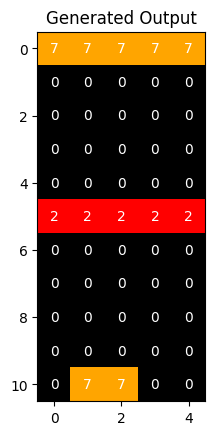

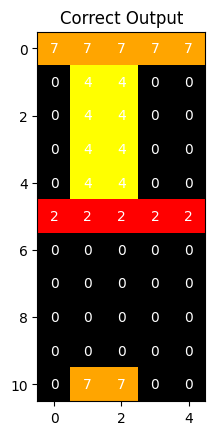

Challenge 11/20 complete. Correct so far: 2/11.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.166300,0.212870
18,0.115300,0.165350
27,0.108700,0.167741
36,0.087100,0.139357


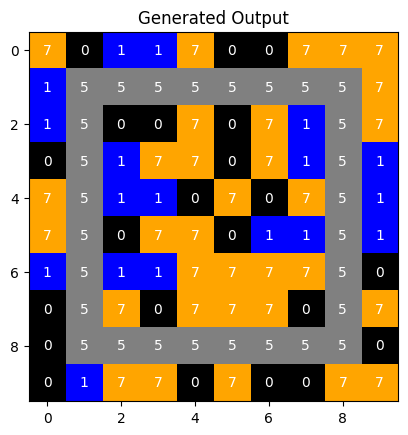

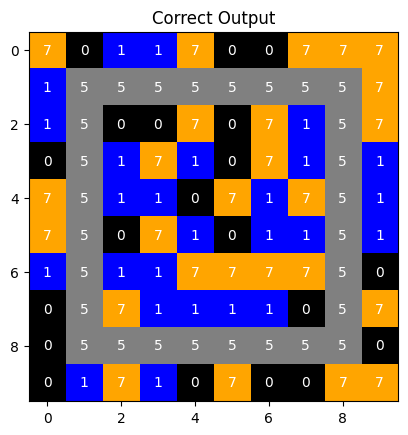

Challenge 12/20 complete. Correct so far: 2/12.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 56


Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 56
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,0.049200,0.076443
24,0.048300,0.056316
36,0.033300,0.082739
48,0.038800,0.058322


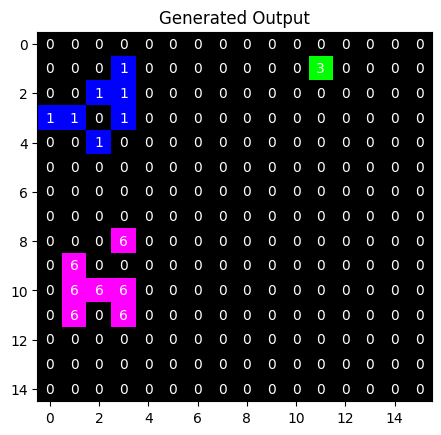

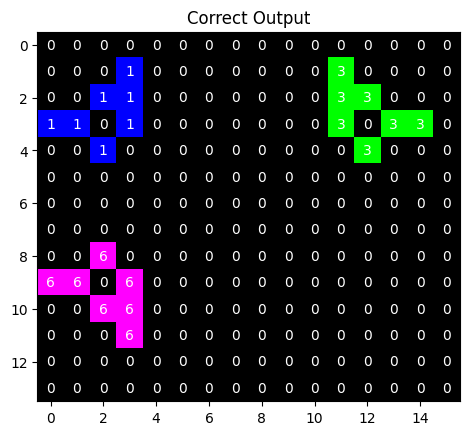

Shape mismatch: Generated (15, 16) vs Expected (14, 16)
Challenge 13/20 complete. Correct so far: 2/13.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.095400,0.125614
18,0.068000,0.102595
27,0.051700,0.104461
36,0.051300,0.098548


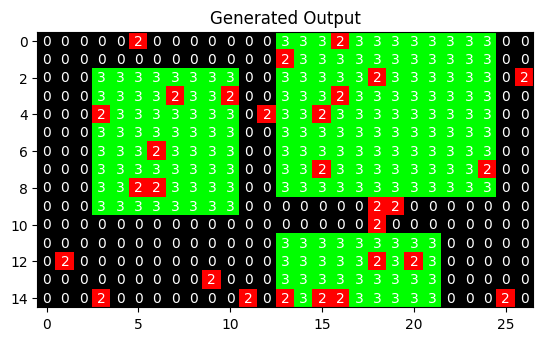

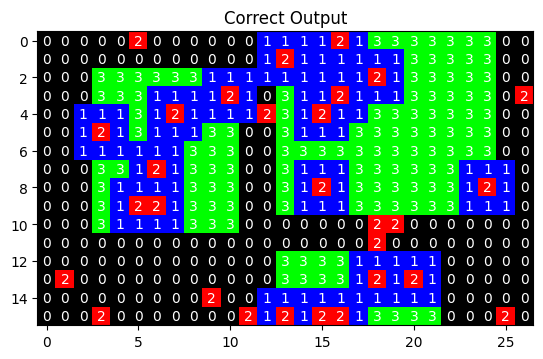

Shape mismatch: Generated (15, 27) vs Expected (16, 27)
Challenge 14/20 complete. Correct so far: 2/14.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.066100,0.100159
12,0.051000,0.081251
18,0.041200,0.082281
24,0.031300,0.071466


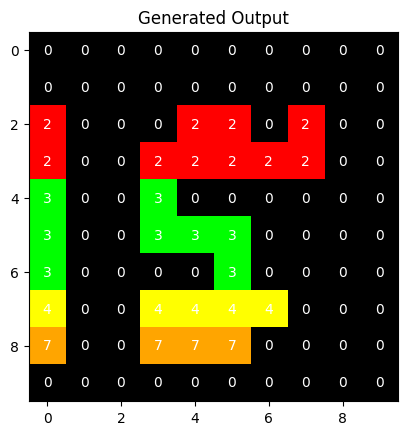

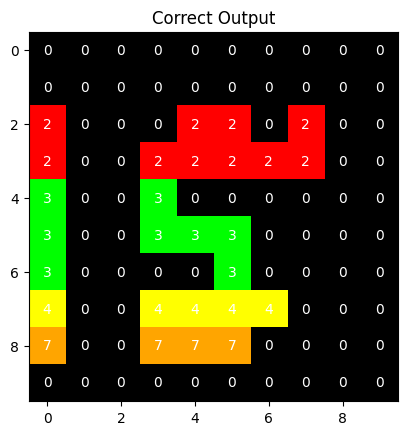

Challenge 15/20 complete. Correct so far: 3/15.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.054100,0.059061
18,0.042300,0.051063
27,0.024800,0.039204
36,0.022300,0.028324


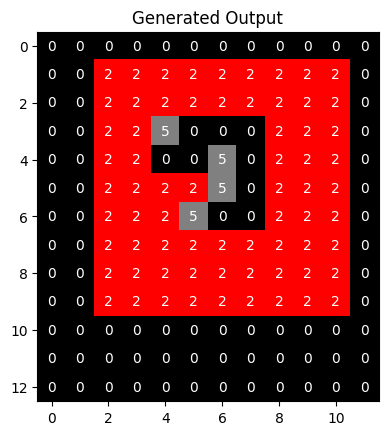

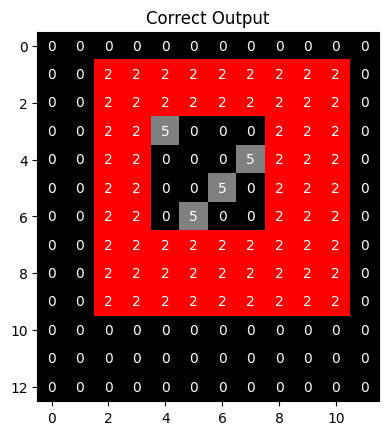

Challenge 16/20 complete. Correct so far: 3/16.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.056100,0.116494
18,0.038300,0.110108
27,0.019800,0.103562
36,0.020600,0.094503


Error in processing: '[' was never closed (<string>, line 1), Generated Output:  [[0 0 0 0 0 0 0 0 0 0]
 [0 6 6 6 9 9 9 0 0 0 0]
 [0 6 6 6 9 9 9 0 0 0 0]
 [0 6 6 6 9 9 9 0 0 0 0]
 [0 7 7 7 8 8 8 0 0 0 0]
 [0 7 7 7 8 8 8 0 0 0 0]
 [0 7 7 7 8 8 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0

Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.033200,0.035941
18,0.025000,0.030936
27,0.013200,0.022948
36,0.015600,0.018019


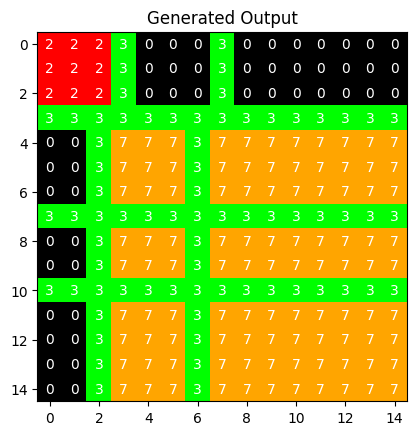

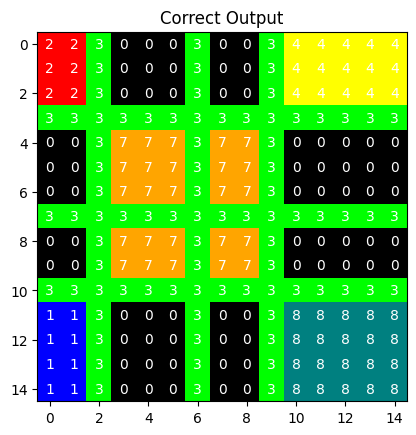

Challenge 18/20 complete. Correct so far: 3/18.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.067100,0.195288
12,0.063700,0.123550
18,0.051300,0.083351
24,0.042900,0.091058


Error in processing: unmatched ']' (<string>, line 1), Generated Output:  [6 0 0 4 0 0 0]
 [0 6 0 4 0 6 6]
 [6 6 6 4 0 6 0]
 [4 4 4 4 4 4 4]
 [0 0 6 4 0 0 0]
 [0 6 6 4 0 2 0]
 [0 0 0 4 0 0 0]
 [4 4 4 4 4 4 4]
 [8 8 0 4 0 0 0]
 [0 8 0 4 0 8 0]
 [8 8 8 4 0 0 0]]


Challenge 19/20 complete. Correct so far: 3/19.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.173600,0.198470
18,0.109600,0.145567
27,0.110800,0.144691
36,0.081200,0.113658


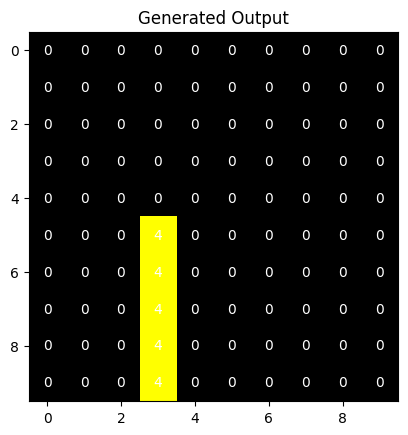

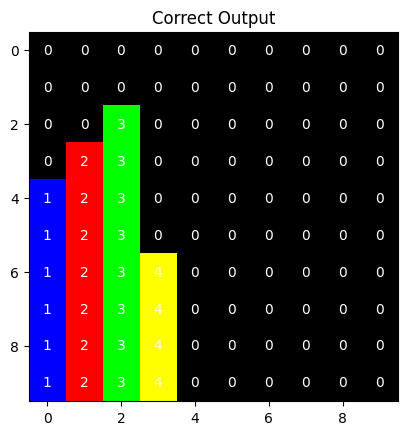

Challenge 20/20 complete. Correct so far: 3/20.
Final Tally: 3/20 challenges correct.


In [368]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from trl import SFTTrainer
from datasets import Dataset
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

# lora_model_name = "Llama-3.2-1B-lora-model"
# lora_model_name = "Llama-3.2-3B-lora-model"
# lora_model_name = "Qwen2.5-Math-1.5B-lora-model"
# lora_model_name = "Qwen2.5-Coder-1.5B-lora-model"

gradient_accumulation_steps=1
batch_size=1
epochs=2

completions_only=False

num_tests = 20 # 83 for full MIT split

# Select the range of challenges to run
dataset_to_run = eval_dataset.select(range(num_tests))

results = []
correct_count = 0

for i, challenge in enumerate(dataset_to_run):  # Iterate directly through the dataset
    # Step 1: Filter the fine-tuning dataset for the current challenge
    challenge_file_name = challenge['file_name']

    challenge_dataset = filter_fine_tuning_dataset(fine_tuning_dataset, challenge_file_name)

    # print(challenge_dataset)
    
    # print(challenge_file_name)

    # del model, tokenizer
    
    # Step 2: Reload the model with the base LoRA
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=lora_model_name,  # Replace with your model's name
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    FastLanguageModel.for_inference(model)  # Enable faster inference

    # Define the Jinja template
    tokenizer.chat_template = """
    {% for message in messages %}
    {{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
    {% endfor %}
    """

    # print(f"Dataset size: {len(challenge_dataset)}")
    # print(f"Epochs: {epochs}")
    # print(f"Batch size: {batch_size}")
    # print(f"Gradient accumulation steps: {gradient_accumulation_steps}")
    # print(f"Computed num_training_steps: {num_training_steps}")
    
    def lr_lambda_specific(current_step: int, num_training_steps: int):
        if num_training_steps < 2:
            # If there are too few steps, return a constant learning rate
            return 1.0
        if current_step < num_training_steps // 2:
            return 1.0  # Constant learning rate for the first half
        else:
            progress = (current_step - num_training_steps // 2) / max(1, (num_training_steps // 2))
            return 0.5 * (1 + torch.cos(torch.tensor(progress * torch.pi)).item())

    # Step 3: Fine-tune the model on the challenge-specific dataset
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    num_training_steps = len(challenge_dataset) * epochs // (batch_size * gradient_accumulation_steps)
    print(f"num train steps: {num_training_steps}")
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda_specific(step, num_training_steps))

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=challenge_dataset,
        eval_dataset=eval_dataset.select([i]),  # Evaluate on the current challenge
        max_seq_length=max_seq_length,
        # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
        dataset_num_proc=2,
        packing=False,
        args=TrainingArguments(
            # group_by_length=False,  # Disable grouping by length (disables shuffling)
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=gradient_accumulation_steps,
            num_train_epochs=epochs,
            logging_strategy="steps",
            logging_dir="logs",
            eval_strategy="steps",
            eval_steps=0.2,
            fp16=not is_bfloat16_supported(),
            bf16=is_bfloat16_supported(),
            logging_steps=0.1,
            optim="adamw_torch",
            seed=3407,
            output_dir="outputs",
            report_to="tensorboard",
        ),
        optimizers=(optimizer, scheduler),  # Pass the custom optimizer and scheduler
    )

    if completions_only:
        print(f"TRAINING ON COMPLETIONS ONLY!")
        # Requires commenting in the datacollator above in the trainer.
        from unsloth.chat_templates import train_on_responses_only
        trainer = train_on_responses_only(
            trainer,
            # instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
            # response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
            instruction_part = "Input:\n",
            response_part = "Test Output:\n",
        )
        
        tokenizer.decode(trainer.train_dataset[0]["input_ids"])
        
        space = tokenizer(" ", add_special_tokens = False).input_ids[0]
        tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])

    trainer.train()  # Fine-tune the model

    # Step 4: Run inference on the fine-tuned model
    result = solve_challenge_unsloth(challenge['messages'], model, tokenizer, visualize=True)
    results.append(result)

    # Update the correct count if the result is correct
    if result.get('is_correct', False):
        correct_count += 1

    print(f"Challenge {i+1}/{len(dataset_to_run)} complete. Correct so far: {correct_count}/{i+1}.")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")

## 8. Submit

For submission you must create a file called 'submission.json' which should have the format as explained [here](www.kaggle.com/competitions/arc-prize-2024/overview/evaluation)

`
{"00576224": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}],
 "009d5c81": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}],
 "12997ef3": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]},
              {"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}],
 ...
}
`

In [ ]:
# print(dataset.select(range(dataset_range))[1])

In [152]:
solution_dict = {}

for i, task in enumerate(dataset.select(range(dataset_range))):
    file_name = task['file_name']

    gen_solution = task["generated_solution"]
    # For now we only do one attempt
    solution_dict[file_name] = [
        {
            "attempt_1": gen_solution,
            "attempt_2": [[0, 0], [0, 0]]
        }
    ]

# Recombining the solutions for split files
combined_solution_dict = {}
combined_files = {}

for file_name, attempts in solution_dict.items():
    base_name = file_name.split('_')[0]
    if base_name not in combined_solution_dict:
        combined_solution_dict[base_name] = []
        combined_files[base_name] = []
    combined_solution_dict[base_name].extend(attempts)
    if '_' in file_name:
        combined_files[base_name].append(file_name)
        
# Printing which file names have been combined
print("Files that have been combined:")
for base_name, files in combined_files.items():
    if files:  # Print only if there are files that were combined
        print(f"{base_name}: {', '.join(files)}")

# We still need to fill in dummy solutions for the tasks we did not consider to make a valid submission:
# Load the sample submission file
if kaggle:
    with open('/kaggle/input/arc-prize-2024/sample_submission.json') as f:
        sample_submission = json.load(f)
else:
    with open('sample_submission.json') as f:
        sample_submission = json.load(f)

# Fill in all entries that are still missing from the sample_submission file
for key, value in sample_submission.items():
    if key not in combined_solution_dict:
        combined_solution_dict[key] = value

# Create submission
with open("submission.json", "w") as json_file:
    json.dump(combined_solution_dict, json_file) 

NameError: name 'dataset_range' is not defined